Lineare Nachbarschafts lter

 In dieser Ubung werden Sie einen linearen Nachbarschafts lter auf einem Bild anwenden und
 die Rahmenbedingungen eines Filters kennenlernen. Wenden Sie die linearen Filter auf das
 Bild Lena.jpg an

1. Lesen Sie das Kapitel 6 (Filter) aus dem Buch Digitale Bildverarbeitung .
 2. Implementieren Sie eine Funktion, die es erlaubt ein Bild (im sinnvollen Rahmen) mit
 frei wahlbaren Filtermasken zu falten

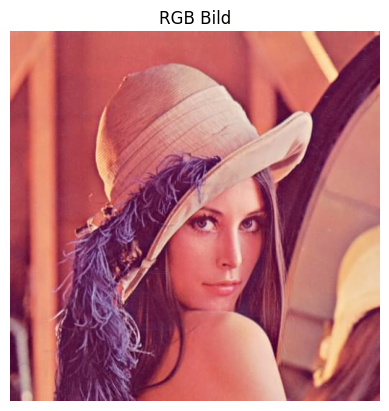

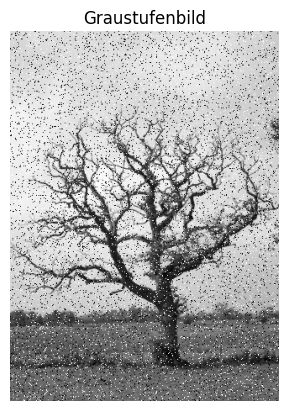

In [10]:
import skimage as ski
import os
from natsort import natsorted, ns
import numpy as np
import matplotlib.pyplot as plt
import heapq

# Liste der Dateinamen (kann alternativ mit os.listdir und natsorted generiert werden)
list_files = ['lena.jpg', 'pepper.jpg', 'tree.png']

# Bilder einlesen
image_list = []
for file in list_files:
    image = ski.io.imread(file)
    image_list.append(image)

# Zeige das zweite Bild (RGB) an
plt.imshow(image_list[0])
plt.title("RGB Bild")
plt.axis('off')
plt.show()

def rgb_to_gray(rgb_img):
    """
    Wandelt ein RGB-Bild in ein 8-Bit Graustufenbild um
    (Berechnung nach der Luminosity-Methode).
    """
    # Berechnung der Graustufenwerte: 0.299*R + 0.587*G + 0.114*B
    # Achtung: skimage.io.imread liefert Bilder häufig im Format (H, W, Channels)
    grayscale_image = 0.299 * rgb_img[:, :, 0] + 0.587 * rgb_img[:, :, 1] + 0.114 * rgb_img[:, :, 2]
    
    # Umwandlung in Ganzzahlen im Bereich 0-255
    grayscale_image = grayscale_image.astype(np.uint8)
    return grayscale_image

# Konvertiere das erste Bild von RGB in Graustufen
img_rgb1 = image_list[2]

#img_gray1 = rgb_to_gray(img_rgb1)  # anzupassendes Bild (Bild01)

# Zeige das Graustufenbild an
plt.imshow(img_rgb1, cmap='gray')
plt.title("Graustufenbild")
plt.axis('off')
plt.show()


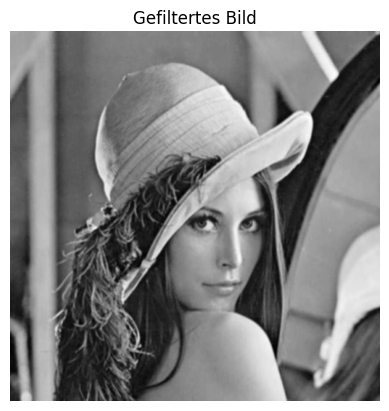

In [11]:
def apply_filter(image, filter_matrix, off):
  

    # Dimensionen des Bildes und des Filters
    image_height, image_width = image.shape
    filter_size = filter_matrix.shape[0]
    k = (filter_size - 1) // 2  # Bestimmt den K-Wert für NxN-Filter
    
    # Berechnen der Ausgabegröße, basierend auf dem Stride
    out_height = (image_height - filter_size) // off + 1
    out_width = (image_width - filter_size) // off + 1
    
    # Leeres Array für das Ergebnisbild
    out_image = np.zeros((out_height, out_width), dtype=np.uint8)
    
    # Faltung durchführen
    for i in range(out_height):
        for j in range(out_width):
            # Region des Bildes, die mit dem Filter gefaltet wird
            region = image[i * off : i * off + filter_size, j * off : j * off + filter_size]
            # Faltung der Region mit der Filtermatrix
            out_image[i, j] = np.sum(region * filter_matrix)
    
    return out_image

# Beispielhafte Filtermatrix (K = 1, 3x3-Filter)
filter_matrix = np.array([[1, 1, 1], 
                          [1, 3, 1], 
                          [1, 1, 1]], dtype=float) / 11

# Beispielbild (Graustufenbild) laden und in Graustufen umwandeln
img_rgb1 = image_list[0]  # z.B. das dritte Bild
img_gray1 = rgb_to_gray(img_rgb1)  # Umwandlung in Graustufen

# Anwenden des Filters mit einem Offset (Stride) von 1
filtered_image = apply_filter(img_gray1, filter_matrix, 1)

# Zeige das gefilterte Bild an
plt.imshow(filtered_image, cmap='gray')
plt.title("Gefiltertes Bild")
plt.axis('off')
plt.show()

a. Nennen Sie die Arten und Eigenschaften von linearen Filtern.

Lineare Filter: Wert des Zielpixels wird als gewichtete Summe der Quellpixel berechnet. Größe und Form der Filterregion und Gewichte des Filter werden durch eine Matrix von Filterkoeffizienten spezifiziert, der Filtermatrix Hij oder Filtermaske.
Arten: Glättungsfilter oder Block, Gauß, Mexican-head?

b. Was ist der Unterschied zwischen linearen und nichtlinearen Filtern?

Nichtlineare Filter werden so wie lineare Filter über eine Umgebung R des Zielpixels mit einer nichtlinearen Funktion f : R → R berechnet: z.B. Minimum-, Maximum- und Median filter

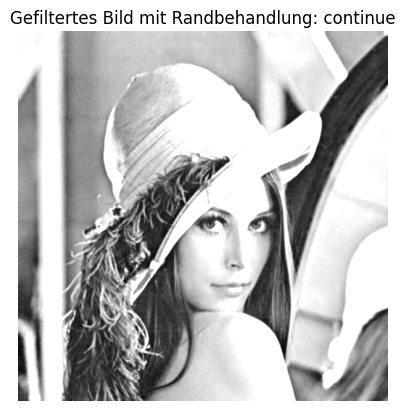

In [12]:
def filter2(image, filter, off, edge):
   
    # Dimensionen des Bildes und des Filters
    image_height, image_width = image.shape
    filter_size = filter.shape[0]
    k = (filter_size - 1) // 2  # Bestimmt den K-Wert für NxN-Filter
    
    # Berechnen der Ausgabegröße
    out_height = (image_height - filter_size) // off + 1
    out_width = (image_width - filter_size) // off + 1

    # Leeres Array für das Ergebnisbild
    out_image = np.zeros((out_height, out_width), dtype=np.uint8)

    # Randbehandlung
    def get_pixel_value(x, y):
     
        if x < 0 or x >= image_height or y < 0 or y >= image_width:
            if edge == "min":
                return 0  # Zero padding
            elif edge == "max":
                return 255  # Maximaler Wert
            elif edge == "continue":
                # Randwert fortsetzen
                x = max(0, min(x, image_height - 1))
                y = max(0, min(y, image_width - 1))
                return image[x, y]
        else:
            return image[x, y]
    
    # Faltung durchführen
    for i in range(out_height):
        for j in range(out_width):
            # Region des Bildes, die mit dem Filter gefaltet wird
            region_sum = 0
            for dx in range(filter_size):
                for dy in range(filter_size):
                    # Berechnung der Bildkoordinaten unter Berücksichtigung der Randbehandlung
                    ix = i * off + dx - k
                    iy = j * off + dy - k
                    region_sum += get_pixel_value(ix, iy) * filter[dx, dy]
            # Setzen des berechneten Pixelwerts in das Ergebnisbild
            out_image[i, j] = np.clip(region_sum, 0, 255)  # Stellen sicher, dass der Wert im gültigen Bereich bleibt
    
    return out_image


# Beispielhafte Filtermatrix
filter_matrix = np.array([[1, 1, 1], 
                          [1, 10, 1], 
                          [1, 1, 1]], dtype=float) / 11

# Beispielbild (Graustufenbild) laden und in Graustufen umwandeln
img_rgb1 = image_list[0]
img_gray1 = rgb_to_gray(img_rgb1)  # Umwandlung in Graustufen

# Beispielaufruf der Funktion mit Randbehandlung "continue"
filtered_image_continue = filter2(img_gray1, filter_matrix, 1, edge="continue")

# Zeige das gefilterte Bild an
plt.imshow(filtered_image_continue, cmap='gray')
plt.title("Gefiltertes Bild mit Randbehandlung: continue")
plt.axis('off')
plt.show()

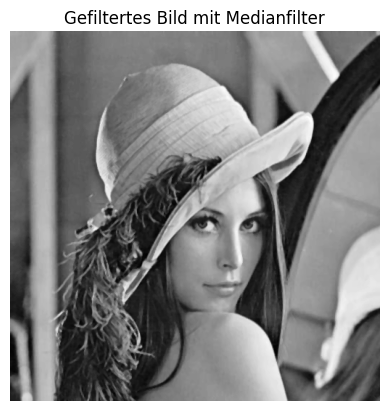

In [13]:
def medianFilter(image, ltersize, o_set):
    
    # Dimensionen des Bildes
    image_height, image_width = image.shape
    k = (ltersize - 1) // 2  # Bestimmung des K-Wertes für NxN Filter
    
    # Berechnung der Größe des Ausgabebildes
    out_height = (image_height - ltersize) // o_set + 1
    out_width = (image_width - ltersize) // o_set + 1

    # Leeres Array für das Ergebnisbild
    out_image = np.zeros((out_height, out_width), dtype=np.uint8)
    
    # Medianfilter anwenden
    for i in range(out_height):
        for j in range(out_width):
            # Region des Bildes, die mit dem Filter bearbeitet wird
            region = []
            for dx in range(ltersize):
                for dy in range(ltersize):
                    # Berechnung der Pixelkoordinaten unter Berücksichtigung des Offsets
                    ix = i * o_set + dx - k
                    iy = j * o_set + dy - k
                    
                    # Überprüfen der Grenzen und Hinzufügen der Pixelwerte zur Region
                    if 0 <= ix < image_height and 0 <= iy < image_width:
                        region.append(image[ix, iy])
            
            # Berechnung des Medians der Region mit Heap Sort
            median_value = heapq.nsmallest(len(region) // 2 + 1, region)[-1]
            out_image[i, j] = median_value
    
    return out_image


img_rgb1 = image_list[0]
img_gray1 = rgb_to_gray(img_rgb1)

filtered_image = medianFilter(img_gray1, 3, 1)

plt.imshow(filtered_image, cmap='gray')
plt.title("Gefiltertes Bild mit Medianfilter")
plt.axis('off')
plt.show()

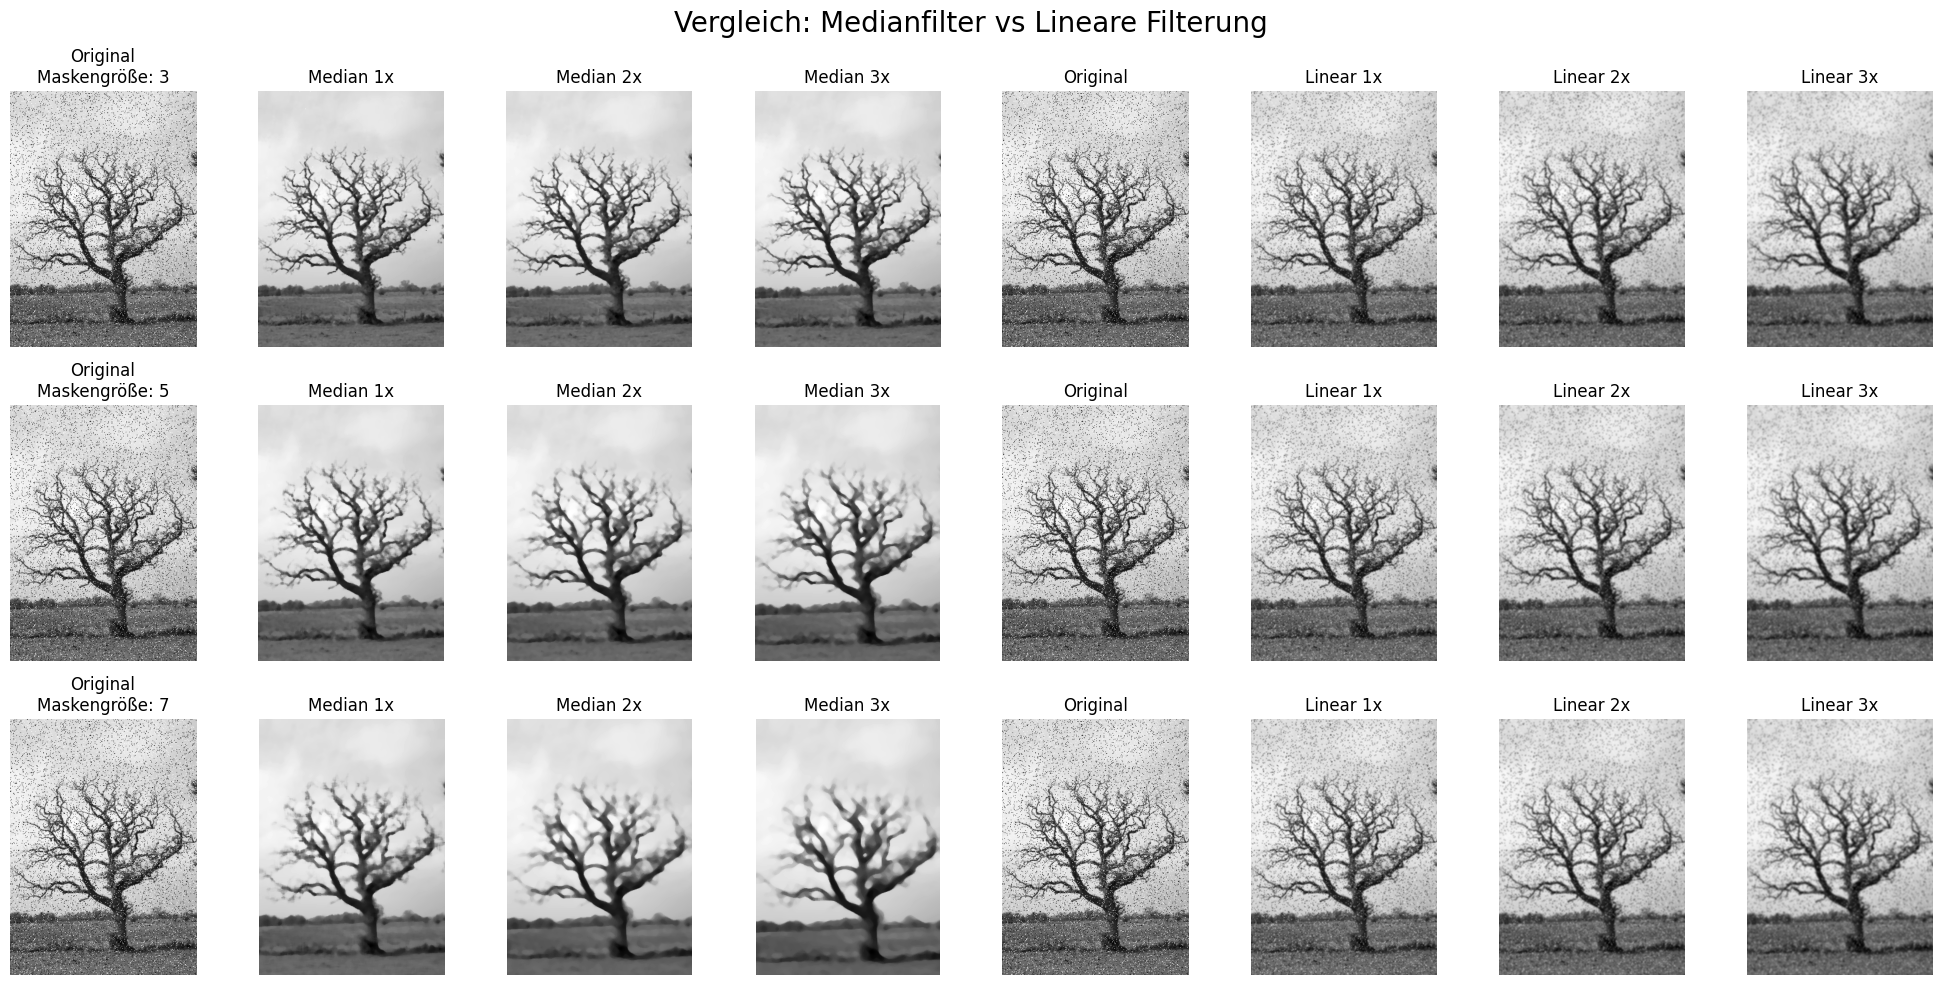

In [14]:
#img_rgbX = image_list[2]
#img_grayX = rgb_to_gray(img_rgbX)
#Für bilder img_list[1&2]
img_grayX = image_list[2]

# Filter-Parameter
mask_sizes = [3, 5, 7]
num_iterations = 3  # wie oft der Filter angewendet werden soll
filter_matrix = np.array([[1, 1, 1],
                          [1, 3, 1],
                          [1, 1, 1]], dtype=float) / 11

# Plot vorbereiten
fig, axes = plt.subplots(len(mask_sizes), 2*num_iterations+2, figsize=(20, 10))
fig.suptitle('Vergleich: Medianfilter vs Lineare Filterung', fontsize=20)

for idx, size in enumerate(mask_sizes):
    # Medianfilterung
    median_img = img_grayX.copy()
    for i in range(num_iterations+1):
        if i > 0:
            median_img = medianFilter(median_img, size, 1)  # bestehende Methode nutzen
        axes[idx, i].imshow(median_img, cmap='gray')
        axes[idx, i].axis('off')
        if i == 0:
            axes[idx, i].set_title(f'Original\nMaskengröße: {size}')
        else:
            axes[idx, i].set_title(f'Median {i}x')

    # Lineare Filterung
    linear_img = img_grayX.copy()
    for i in range(num_iterations+1):
        if i > 0:
            linear_img = apply_filter(linear_img, filter_matrix, 1)  # bestehende Methode nutzen
        axes[idx, i+num_iterations+1].imshow(linear_img, cmap='gray')
        axes[idx, i+num_iterations+1].axis('off')
        if i == 0:
            axes[idx, i+num_iterations+1].set_title('Original')
        else:
            axes[idx, i+num_iterations+1].set_title(f'Linear {i}x')

plt.tight_layout()
plt.show()

a. Vergleichen Sie die Ergebnisse der verschiedenen Filter miteinander und begruenden Sie diese.
Lineare Filter:

    verursacht ein allgemeines Weichzeichnen, entfernt hochfrequentes Rauschen, aber auch feine Details und Kanten werden verschwommen.

    durch die höhere Gewichtung in der Mitte bleibt das Bild etwas schärfer als bei reinem Durchschnitt, aber trotzdem sichtbar unschärfer als nach Medianfilterung.

Medianfilter:
    Der Medianfilter entfernt Impulsrauschen (z.B. Salz-und-Pfeffer-Rauschen) sehr gut.

    Er bewahrt dabei scharfe Kanten besser als Mittelwert-Filter, da der Median nicht von extremen Werten beeinflusst wird.

    Bild wirkt geglättet, aber Details wie Konturen bleiben besser erhalten.

Vergleich:

    Medianfilter: besser bei Ausreißern und Kantenbewahrung.

    Lineare Filter: besser für leichtes, gleichmäßiges Weichzeichnen, aber Details gehen stärker verloren.

b. Warum ist es beim Medianfilter sinnvoll fur die Sortierung Heap Sort zu verwenden?

Heap Sort erlaubt es, effizient das k-kleinste Element zu finden, ohne die gesamte Liste vollständig zu sortieren. -> verringerte Laufzeit

c. Untersuchen Sie, welche Effekte bei mehrmaligem Anwenden eines Filters auf das jeweilige Ergebnisbild auftreten.

Medianfilter mehrfach anwenden:

    Verstärkte Glättung von Ausreißern, aber Formen und Kanten bleiben lange erhalten.

    Nach sehr vielen Anwendungen kann das Bild aber auch anfangen zu "verklumpen" (Flächen gleichen Grauwert).

Lineare Filter mehrfach anwenden:

    Starke Weichzeichnung.

    Details und Kanten verschwinden nach mehrmaliger Anwendung zunehmend.

d. Welche Effekte treten bei grossen und bei kleinen Filtermasken auf?

Kleine Filtermasken (z.B. 3x3, 5x5):

    Feine Glättung: kleine Bildstrukturen bleiben größtenteils erhalten.

    Wenig Einfluss auf große Bildbereiche.

    Medianfilter mit kleiner Maske entfernt nur sehr punktuelles Rauschen.

Große Filtermasken (z.B. 7x7, 11x11 oder größer):

    Stärkere Glättung, großflächiges Weichzeichnen.

    Details und Kanten werden stärker verwischt.

    Medianfilter: größere Flächen mit ähnlichen Werten entstehen → weniger Struktur im Bild.

    linearen Filter: Bilder erscheinen unscharf und verlieren schnell an Information.
